<h3>1. Obtain and review raw data</h3>

This is a study project for analyzing fitness tracker data collected over the period 2012-2018.
Data source: https://app.datacamp.com/

In [23]:
import pandas as pd

runkeeper_file = 'datasets/cardioActivities.csv'
df_activities = pd.read_csv(runkeeper_file, parse_dates=True, index_col='Date')

# First look at exported data: select sample of 3 random rows 
display(df_activities.sample(3))

print(df_activities.info())

,Activity Id,Type,Route Name,Distance (km),Duration,Average Pace,Average Speed (km/h),Calories Burned,Climb (m),Average Heart Rate (bpm),Friend's Tagged,Notes,GPX File
Date,,,,,,,,,,,,,
2015-11-09 18:21:31,df774be0-d4a3-4104-a9e4-ee120e17bcba,Running,NaN,9.72,55:01,5:40,10.60,659.0,89,131.0,NaN,TomTom MySports Watch,2015-11-09-182131.gpx
2015-02-12 18:22:44,2c5f4777-b55a-43b2-82f3-d633c19bbdc8,Running,NaN,6.75,36:25,5:24,11.12,485.0,42,NaN,NaN,NaN,2015-02-12-182244.gpx
2018-11-01 14:03:58,bc9b612d-3499-43ff-b82a-9b17b71b8a36,Running,NaN,12.98,1:14:25,5:44,10.47,960.0,169,158.0,NaN,NaN,2018-11-01-140358.gpx


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 508 entries, 2018-11-11 14:05:12 to 2012-08-22 18:53:54
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Activity Id               508 non-null    object 
 1   Type                      508 non-null    object 
 2   Route Name                1 non-null      object 
 3   Distance (km)             508 non-null    float64
 4   Duration                  508 non-null    object 
 5   Average Pace              508 non-null    object 
 6   Average Speed (km/h)      508 non-null    float64
 7   Calories Burned           508 non-null    float64
 8   Climb (m)                 508 non-null    int64  
 9   Average Heart Rate (bpm)  294 non-null    float64
 10  Friend's Tagged           0 non-null      float64
 11  Notes                     231 non-null    object 
 12  GPX File                  504 non-null    object 
dtypes: float64(5), int64(1), obj

## 2. Data preprocessing

<p>There are some missing values in the dataset. What are the reasons for these missing values? It depends. Some heart rate information is missing because fitness tracker's owner didn't always use a cardio sensor. In the case of the <code>Notes</code> column, it is an optional field that sometimes left blank. Also, user only used the <code>Route Name</code> column once, and never used the <code>Friend's Tagged</code> column.</p>
<p>So we remove columns with lots of missing values.</p>
<p>Also we replace the "Other" activity type to "Unicycling" because that was always the "Other" activity.</p>


In [24]:
# Delete unnecessary columns
cols_to_drop = ['Friend\'s Tagged','Route Name','GPX File','Activity Id','Calories Burned', 'Notes']
df_activities.drop(columns=cols_to_drop, inplace=True)

# Count types of training activities
display(df_activities['Type'].value_counts())

# Rename 'Other' type to 'Unicycling'
df_activities['Type'] = df_activities['Type'].str.replace('Other', 'Unicycling')

# Count missing values for each column
df_activities.isnull().sum()

Running    459
Cycling     29
Walking     18
Other        2
Name: Type, dtype: int64

Type                          0
Distance (km)                 0
Duration                      0
Average Pace                  0
Average Speed (km/h)          0
Climb (m)                     0
Average Heart Rate (bpm)    214
dtype: int64

## 3. Dealing with missing values
<p>As we can see from the last output, there are 214 missing entries for the average heart rate.</p>
<p>We can fill in the missing values with an average value, considering that the average heart rate varies for different activities (e.g., walking vs. running).</p>

In [25]:
# Calculate sample means for heart rate for each training activity type 
avg_hr_run = df_activities[df_activities['Type'] == 'Running']['Average Heart Rate (bpm)'].mean()
avg_hr_cycle = df_activities[df_activities['Type'] == 'Cycling']['Average Heart Rate (bpm)'].mean()

# Split whole DataFrame into several, specific for different activities
df_run = df_activities[df_activities['Type'] == 'Running'].copy()
df_walk = df_activities[df_activities['Type'] == 'Walking'].copy()
df_cycle = df_activities[df_activities['Type'] == 'Cycling'].copy()

# Filling missing values with counted means  
df_walk['Average Heart Rate (bpm)'].fillna(110, inplace=True)
df_run['Average Heart Rate (bpm)'].fillna(int(avg_hr_run), inplace=True)
df_cycle['Average Heart Rate (bpm)'].fillna(int(avg_hr_cycle), inplace=True)

# Count missing values for each column in running data
df_run.isnull().sum()


Type                        0
Distance (km)               0
Duration                    0
Average Pace                0
Average Speed (km/h)        0
Climb (m)                   0
Average Heart Rate (bpm)    0
dtype: int64

## 4. Plot running data
<p>As we found earlier, most of the activities in my data were running (459 of them to be exact). There are only 29, 18, and two instances for cycling, walking, and unicycling, respectively.</p>
<p>A first visualization is a figure with four subplots, one for each running metric (each numerical column). Each subplot will have a different y-axis, which is explained in each legend. The x-axis, <code>Date</code>, is shared among all subplots.</p>

/var/folders/wn/4h_858r92h7cccm1g836wdcw0000gp/T/ipykernel_93744/3668605669.py:13: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  runs_subset_2013_2018 = df_run['2013':'2018']


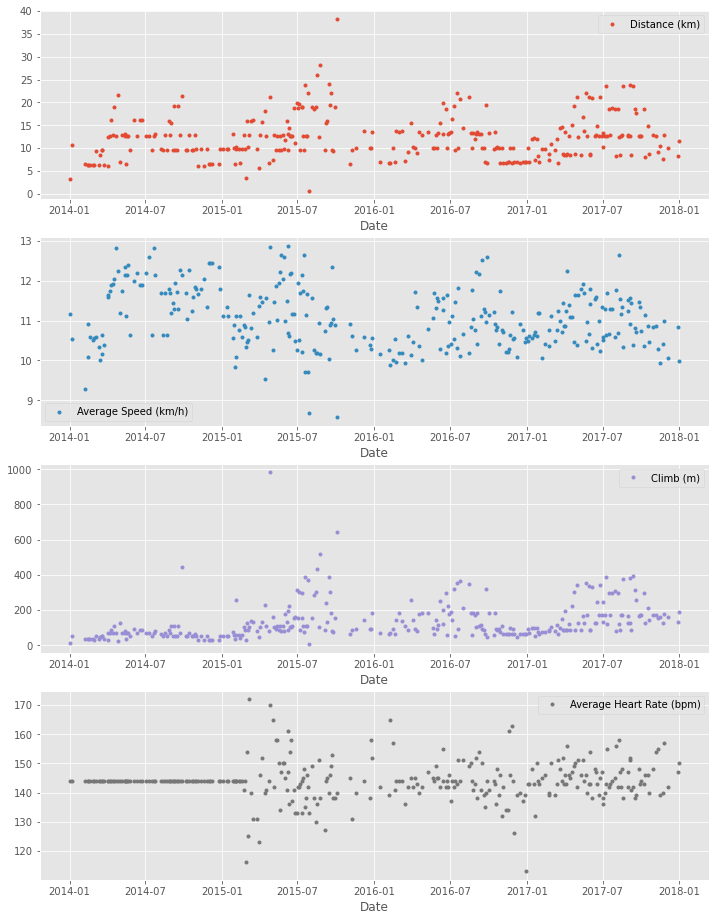

In [26]:
%matplotlib inline

import matplotlib.pyplot as plt

import warnings
plt.style.use('ggplot')
warnings.filterwarnings(
    action='ignore', module='matplotlib.figure', category=UserWarning,
    message=('This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.')
)

# Prepare data subsetting period from 2013 till 2018, create and customize plot
runs_subset_2013_2018 = df_run['2013':'2018']

runs_subset_2013_2018.plot(subplots=True,
                           sharex=False,
                           figsize=(12,16),
                           linestyle='none',
                           marker='o',
                           markersize=3,
                          )

plt.show()

## 5. Running statistics
<p>Common questions about running are like:</p>
<ul>
<li>What is your average distance?</li>
<li>How fast do you run?</li>
<li>Do you measure your heart rate?</li>
<li>How often do you train?</li>
</ul>
<p>Let's find the answers to these questions in data. On plots in section 4, you can see the answer to, <em>Do you measure your heart rate?</em> Before 2015: no. To look at the averages, use the data from 2015 through 2018.</p>
<p>In pandas, the <code>resample()</code> method is similar to the <code>groupby()</code> method - with <code>resample()</code> you group by a specific time span. We'll use <code>resample()</code> to group the time series data by a sampling period and apply several methods to each sampling period. In our case, we'll resample annually and weekly.</p>

In [27]:
runs_subset_2015_2018 = df_run['2015':'2018']

# Calculate annual statistics
print('How my average run looks in last 4 years:')
display(runs_subset_2015_2018.resample('A').mean())

# Calculate weekly statistics
print('Weekly averages of last 4 years:')
display(runs_subset_2015_2018.resample('W').mean().mean())

# Mean weekly counts
weekly_counts_average = round(runs_subset_2015_2018['Distance (km)'].resample('W').count().mean(),2)
print('How many trainings per week I had on average:', weekly_counts_average)

How my average run looks in last 4 years:


/var/folders/wn/4h_858r92h7cccm1g836wdcw0000gp/T/ipykernel_93744/3363263378.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  runs_subset_2015_2018 = df_run['2015':'2018']


,Distance (km),Average Speed (km/h),Climb (m),Average Heart Rate (bpm)
Date,,,,
2016-12-31,11.411667,10.837778,133.194444,143.388889
2017-12-31,12.935176,10.959059,169.376471,145.247059


Weekly averages of last 4 years:


Distance (km)                12.020315
Average Speed (km/h)         10.848722
Climb (m)                   149.483333
Average Heart Rate (bpm)    144.551852
dtype: float64

How many trainings per week I had on average: 1.52


## 6. Visualization with averages
<p>Let's plot the long term averages of distance run and heart rate with their raw data to visually compare the averages to each training session. Again, we'll use the data from 2015 through 2018.</p>
<p>In this task, we will use <code>matplotlib</code> functionality for plot creation and customization.</p>

/var/folders/wn/4h_858r92h7cccm1g836wdcw0000gp/T/ipykernel_93744/3618066044.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  runs_subset_2015_2018 = df_run['2015':'2018']


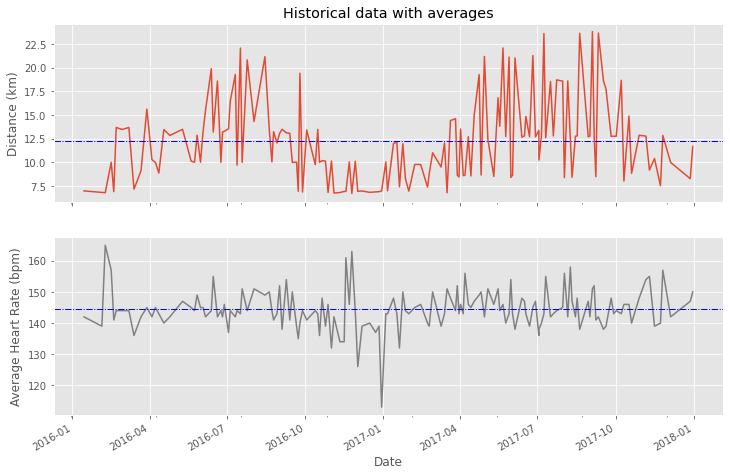

In [28]:
runs_subset_2015_2018 = df_run['2015':'2018']
runs_distance = runs_subset_2015_2018['Distance (km)']
runs_hr = runs_subset_2015_2018['Average Heart Rate (bpm)']

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,8))

runs_distance.plot(ax=ax1)
ax1.set(ylabel='Distance (km)', title='Historical data with averages')
ax1.axhline(runs_distance.mean(), color='blue', linewidth=1, linestyle='-.')

runs_hr.plot(ax=ax2, color='gray')
ax2.set(xlabel='Date', ylabel='Average Heart Rate (bpm)')
ax2.axhline(runs_hr.mean(), color='blue', linewidth=1, linestyle='-.')

plt.show()

## 7. Did I reach my goals?
<p>To motivate himself to run regularly, fitness tracker's user set a target goal of running 1000 km per year. Let's visualize his annual running distance (km) from 2013 through 2018 to see if he reached his goal each year. Only stars in the green region indicate success.</p>

/var/folders/wn/4h_858r92h7cccm1g836wdcw0000gp/T/ipykernel_93744/1771091380.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_run = df_run['2013':'2018']


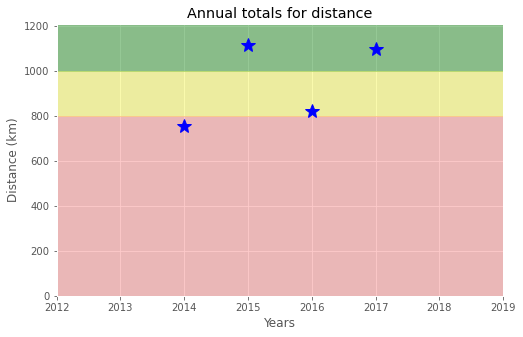

In [29]:
df_run = df_run['2013':'2018']
df_run_dist_annual = df_run['Distance (km)'].resample('A').sum()

fig = plt.figure(figsize=(8,5))

ax = df_run_dist_annual.plot(marker='*', markersize=14, linewidth=0, color='blue')
ax.set(ylim=[0, 1210], 
       xlim=['2012','2019'],
       ylabel='Distance (km)',
       xlabel='Years',
       title='Annual totals for distance')

ax.axhspan(1000, 1210, color='green', alpha=0.4)
ax.axhspan(800, 1000, color='yellow', alpha=0.3)
ax.axhspan(0, 800, color='red', alpha=0.2)

plt.show()

## 8. Am I progressing?
<p>Let's dive a little deeper into the data to answer a tricky question: am I progressing in terms of my running skills? </p>
<p>To answer this question, we'll decompose my weekly distance run and visually compare it to the raw data. A red trend line will represent the weekly distance run.</p>
<p>We are going to use <code>statsmodels</code> library to decompose the weekly trend.</p>

/var/folders/wn/4h_858r92h7cccm1g836wdcw0000gp/T/ipykernel_93744/1188309586.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_run_dist_wkly = df_run['2013':'2018']['Distance (km)'].resample('W').bfill()


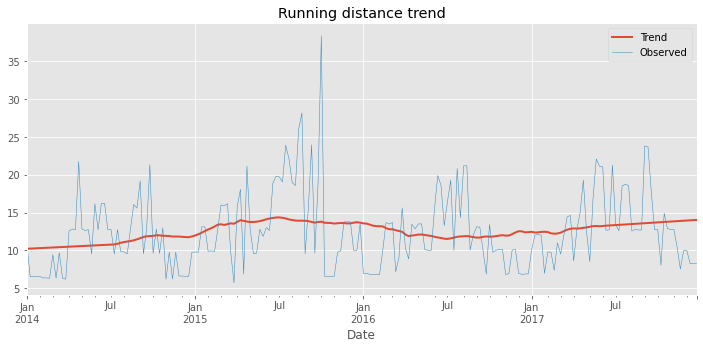

In [30]:
import statsmodels.api as sm

df_run_dist_wkly = df_run['2013':'2018']['Distance (km)'].resample('W').bfill()
df_run_dist_wkly = df_run_dist_wkly.dropna(axis=0)

decomposed = sm.tsa.seasonal_decompose(df_run_dist_wkly, extrapolate_trend=1)

fig = plt.figure(figsize=(12,5))

ax = decomposed.trend.plot(label='Trend', linewidth=2)
ax = decomposed.observed.plot(label='Observed', linewidth=0.5)

ax.legend()
ax.set_title('Running distance trend')

plt.show()

## 9. Training intensity
<p>Heart rate is a popular metric used to measure training intensity. Depending on age and fitness level, heart rates are grouped into different zones that people can target depending on training goals. A target heart rate during moderate-intensity activities is about 50-70% of maximum heart rate, while during vigorous physical activity it’s about 70-85% of maximum.</p>
<p>We'll create a distribution plot of heart rate data by training intensity. It will be a visual presentation for the number of activities from predefined training zones. </p>

/var/folders/wn/4h_858r92h7cccm1g836wdcw0000gp/T/ipykernel_93744/1855480886.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_run_hr_all = df_run['2015-03':'2018']['Average Heart Rate (bpm)']


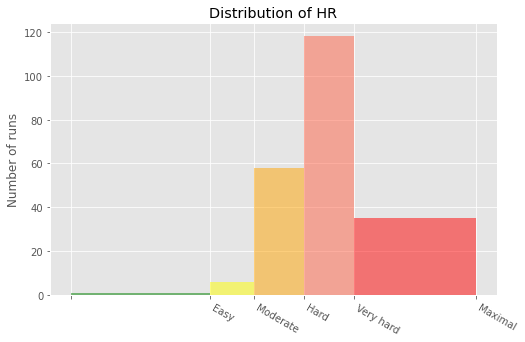

In [31]:
hr_zones = [100, 125, 133, 142, 151, 173]
zone_names = ['','Easy', 'Moderate', 'Hard', 'Very hard', 'Maximal']
zone_colors = ['green', 'yellow', 'orange', 'tomato', 'red']
df_run_hr_all = df_run['2015-03':'2018']['Average Heart Rate (bpm)']

fig, ax = plt.subplots(figsize=(8,5))

n, bins, patches = ax.hist(df_run_hr_all, bins=hr_zones, alpha=0.5)
for i in range(0, len(patches)):
    patches[i].set_facecolor(zone_colors[i])

ax.set(title='Distribution of HR', ylabel='Number of runs')
ax.xaxis.set(ticks=hr_zones)
ax.set_xticklabels(labels=zone_names, rotation=-30, ha='left')

plt.show()

## 10. Detailed summary report
<p>The first table will be a summary of the distance (km) and climb (m) variables for each training activity. The second table will list the summary statistics for the average speed (km/hr), climb (m), and distance (km) variables for each training activity.</p>

In [32]:
# Concatenating three DataFrames
df_run_walk_cycle = df_run.append(df_walk).append(df_cycle).sort_index(ascending=False)

dist_climb_cols, speed_col = ['Distance (km)', 'Climb (m)'], ['Average Speed (km/h)']

# Calculating total distance and climb in each type of activities
df_totals = df_run_walk_cycle.groupby('Type')[dist_climb_cols].sum()

print('Totals for different training types:')
display(df_totals)

# Calculating summary statistics for each type of activities 
df_summary = df_run_walk_cycle.groupby('Type')[dist_climb_cols + speed_col].describe()

# Combine totals with summary
for i in dist_climb_cols:
    df_summary[i, 'total'] = df_totals[i]

print('Summary statistics for different training types:')
df_summary.stack()

Totals for different training types:


,Distance (km),Climb (m)
Type,,
Cycling,680.58,6976
Running,3792.32,41625
Walking,33.45,349


Summary statistics for different training types:


Average Speed (km/h)     Climb (m)  Distance (km)
Type                                                            
Cycling 25%               16.980000    139.000000      15.530000
        50%               19.500000    199.000000      20.300000
        75%               21.490000    318.000000      29.400000
        count             29.000000     29.000000      29.000000
        max               24.330000    553.000000      49.180000
        mean              19.125172    240.551724      23.468276
        min               11.380000     58.000000      11.410000
        std                3.257100    128.960289       9.451040
        total                   NaN   6976.000000     680.580000
Running 25%               10.527500     68.000000       9.550000
        50%               11.000000     97.500000      12.475000
        75%               11.630000    170.250000      13.585000
        count            308.000000    308.000000     308.000000
        max               12.880000    982.000000      38.320000
        mean              11.066786    135.146104      12.312727
        min                8.570000      6.000000       0.760000
        std                0.745171    108.132872       4.779396
        total                   NaN  41625.000000    3792.320000
Walking 25%                5.555000      7.000000       1.385000
        50%                5.970000     10.000000       1.485000
        75%                6.512500     15.500000       1.787500
        count             18.000000     18.000000      18.000000
        max                6.910000    112.000000       4.290000
        mean               5.549444     19.388889       1.858333
        min                1.040000      5.000000       1.220000
        std                1.459309     27.110100       0.880055
        total                   NaN    349.000000      33.450000